# Parameterizing molecules on the fly

Since the version [5.0, FoldX](https://academic.oup.com/bioinformatics/article/35/20/4168/5381539) allows for the user parameterization of molecules previously not recognized by the software. 

For a comprehensive list of molecules recognized by FoldX follow [this link](http://foldxsuite.crg.eu/allowed-residues).

In [1]:
# This simulates the installation the user will just import pyFoldx.Structure
import sys
sys.path.append("/home/lradusky/Dropbox/workspacesbg/pyFoldX")

In [18]:
from src.handlers.FileHandler import FileHandler
from src.structure.Structure import Structure
from src.pyFoldX.moleculeParameterization import parameterize, PdbMolecule, JSonMolecule

from IPython import display 

In this tutorial, we are going to use the [PDB 2B3B](https://www.rcsb.org/structure/2B3B), "Thermus thermophilus Glucose/Galactose Binding Protein With Bound Glucose". This structure possess a glucose ligand (code="GLC") that is not originally recognized by FoldX.

## **Step 1**: Extract the molecule coordinates from the PDB

We are going to load the structure and keep the lines of the molecule we want to parameterize.

In [3]:
st = Structure("2B3B")

The *Structure* class has a *data* dictionary organized by chains, residues and atoms.

In [4]:
# Identifying GLC Residues
for chain in st.data.keys():
    for residue in st.data[chain]:
        if st.data[chain][residue].code == "GLC":
            print( st.data[chain][residue] )

Residue(GLC,2605,A,True)
Residue(GLC,2606,B,True)
Residue(GLC,2609,E,True)
Residue(GLC,2610,F,True)


As we can observe, we have four GLC residues, one for each chain. Since each chain represents for this structure one biological assembly we are going to keep just the chain A for further analysis.

In [5]:
# We overwrite the structure object with its chain A
st_A = Structure( "2B3B_A", fromString= st.toPdb(chain="A") )

# And we save it to generate further figures
FileHandler.writeLines("data/parameterization/WT.pdb", st_A.toPdb())

True

In [6]:
# Identifying GLC Residues
for chain in st_A.data.keys():
    for residue in st_A.data[chain]:
        if st_A.data[chain][residue].code == "GLC":
            print( st_A.data[chain][residue] )

Residue(GLC,2605,A,True)


The lines containing the PDB coordinates of this molecule will be one of our inputs.

In [7]:
glcLines = st_A.data["A"][2605].getInPDBFormat().split("\n")

In [8]:
glcLines

['HETATM18215  C1  GLC A2605      10.283  65.776  23.204  1.00 20.33           C  ',
 'HETATM18216  C2  GLC A2605       8.995  64.925  22.926  1.00 18.08           C  ',
 'HETATM18217  C3  GLC A2605       8.531  64.856  21.464  1.00 16.36           C  ',
 'HETATM18218  C4  GLC A2605       8.922  66.123  20.698  1.00 15.64           C  ',
 'HETATM18219  C5  GLC A2605      10.438  66.374  20.803  1.00 15.84           C  ',
 'HETATM18220  C6  GLC A2605      10.944  67.649  20.109  1.00 14.64           C  ',
 'HETATM18221  O1  GLC A2605      11.249  65.183  23.989  1.00 21.33           O  ',
 'HETATM18222  O2  GLC A2605       8.941  63.665  23.616  1.00 17.59           O  ',
 'HETATM18223  O3  GLC A2605       7.116  64.746  21.457  1.00 17.28           O  ',
 'HETATM18224  O4  GLC A2605       8.565  65.995  19.332  1.00 15.51           O  ',
 'HETATM18225  O5  GLC A2605      10.908  66.472  22.137  1.00 14.15           O  ',
 'HETATM18226  O6  GLC A2605      10.341  68.786  20.652  1.00 14

## **Step 2**: Mapping the atoms to parametrized atoms

**TODO** Rename the atoms to its rational name, instead of specifying the molecule and atom to steel from.

We are going to create a dictionary specifying which type of atom is each atom in the GLC molecule.


In [9]:
st_A.data["A"][2605].atoms

[Atom(C1,18215,10.283,65.776,23.204,Residue(GLC,2605,A,True),20.33),
 Atom(C2,18216,8.995,64.925,22.926,Residue(GLC,2605,A,True),18.08),
 Atom(C3,18217,8.531,64.856,21.464,Residue(GLC,2605,A,True),16.36),
 Atom(C4,18218,8.922,66.123,20.698,Residue(GLC,2605,A,True),15.64),
 Atom(C5,18219,10.438,66.374,20.803,Residue(GLC,2605,A,True),15.84),
 Atom(C6,18220,10.944,67.649,20.109,Residue(GLC,2605,A,True),14.64),
 Atom(O1,18221,11.249,65.183,23.989,Residue(GLC,2605,A,True),21.33),
 Atom(O2,18222,8.941,63.665,23.616,Residue(GLC,2605,A,True),17.59),
 Atom(O3,18223,7.116,64.746,21.457,Residue(GLC,2605,A,True),17.28),
 Atom(O4,18224,8.565,65.995,19.332,Residue(GLC,2605,A,True),15.51),
 Atom(O5,18225,10.908,66.472,22.137,Residue(GLC,2605,A,True),14.15),
 Atom(O6,18226,10.341,68.786,20.652,Residue(GLC,2605,A,True),14.44)]

For each atom, we specify its template

In [10]:
atomMappingsDict = {"C1":("C1*","A"),
                    "C2":("C3*","A"),
                    "O1":("O3*","T"),
                    "O2":("O3*","A"),
                    "C3":("O3*","G"),
                    "O3":("O3*","G"),
                    "C4":("C3*","C"),
                    "O4":("O3*","C"),
                    "C5":("C4*","A"),
                    "C6":("C5*","A"),
                    "O5":("O4*","A"),
                    "O6":("OG","SER")}

## **Step 3**: Creating the JSON molecule parameter file

With the **PDBMolecule** class, instanciated with the lines of the the molecule, and the mappings, we can create a **JSonMolecule** object with the parameters ready to be used by FoldX.

In [11]:
newMol = parameterize( PdbMolecule(fromString=glcLines), atomMappingsDict)

Mappings loaded:
Atom C1 mapped to atom C1* of molecule A
Atom C2 mapped to atom C3* of molecule A
Atom O1 mapped to atom O3* of molecule T
Atom O2 mapped to atom O3* of molecule A
Atom C3 mapped to atom O3* of molecule G
Atom O3 mapped to atom O3* of molecule G
Atom C4 mapped to atom C3* of molecule C
Atom O4 mapped to atom O3* of molecule C
Atom C5 mapped to atom C4* of molecule A
Atom C6 mapped to atom C5* of molecule A
Atom O5 mapped to atom O4* of molecule A
Atom O6 mapped to atom OG of molecule SER


In [12]:
type(newMol)

src.pyFoldX.moleculeParameterization.JSonMolecule

We save the parameters file in the molecules folder, ready to be read by FoldX.

In [13]:
FileHandler.writeLine("molecules/GLC.json", newMol.toJson())

True

## Testing the Results

To test the results, we are going to make a copy of the structure without the GLC molecule, and mutate a residue contacting GLC, the aspartic acid 278 to histidine, a bigger residue that will clash with the glucose.

In [27]:
# We filter out the lines of the GLC
linesWithoutGLC = [x for x in st.toPdb(chain="A") if x.find("GLC") == -1]
# And we make a new Structure object with this filtered lines.
st_A_no_GLC = Structure("2B3B_A_no_GLC", fromString=linesWithoutGLC)

In [15]:
# We mutate and store the mutated and wildtype models.
energyDf_GLC, ensMut_GLC, ensWT_GLC          = st_A.mutate("DA278H;", generateMutationsEnsemble=True)
energyDf_no_GLC, ensMut_no_GLC, ensWT_no_GLC = st_A_no_GLC.mutate("DA278H;", generateMutationsEnsemble=True)

# And we save it to generate further figures
FileHandler.writeLines("data/parameterization/Mutated_GLC.pdb", ensMut_GLC.frames[0].toPdb())
FileHandler.writeLines("data/parameterization/Mutated_no_GLC.pdb", ensMut_no_GLC.frames[0].toPdb())

Computing mutation(s) DA278H; on target structure...
Energy computed.
Computing mutation(s) DA278H; on target structure...
Energy computed.


True

Lets observe the neighbour of the mutated zone in the wildtype structure:

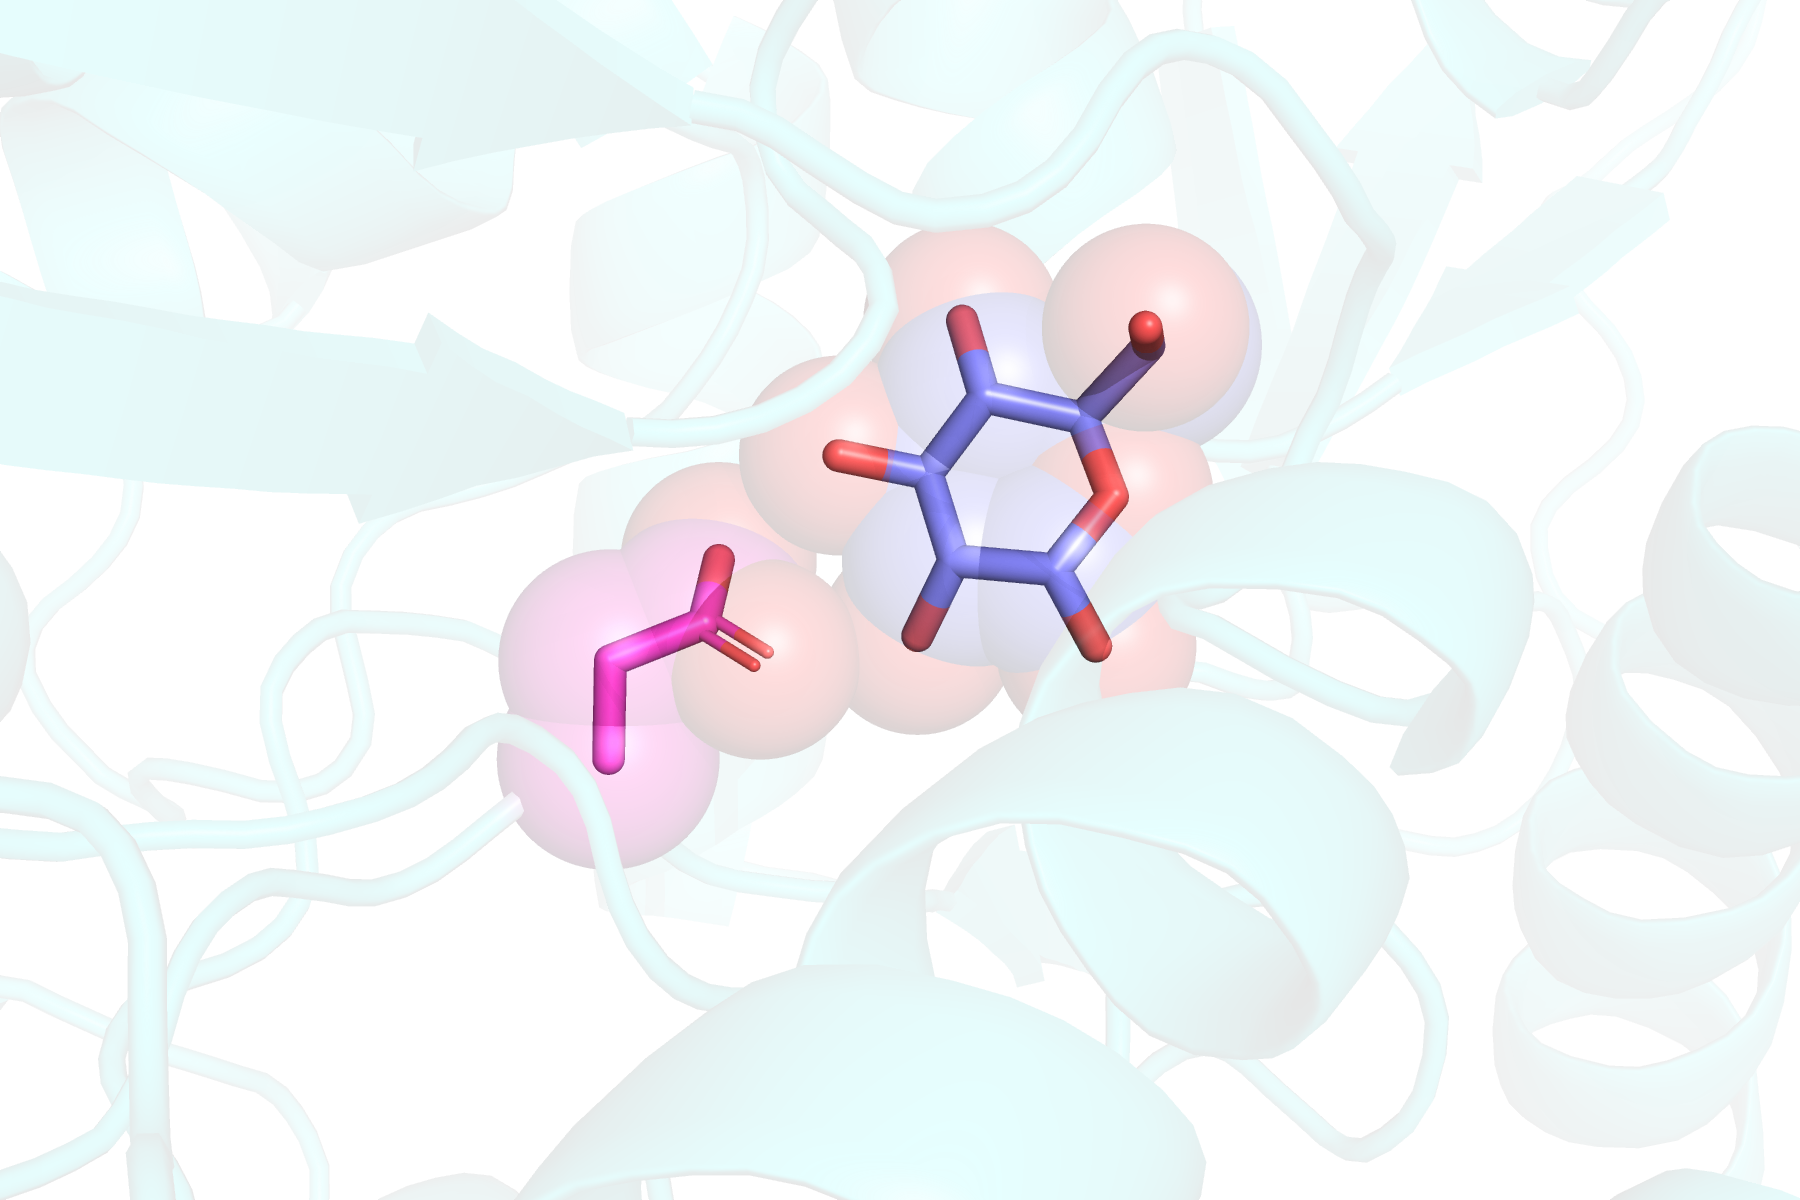

In [20]:
display.Image("./data/parameterization/wildType.png", width=600, height=600)

When we mutate without considering the ligand, the energy increases.

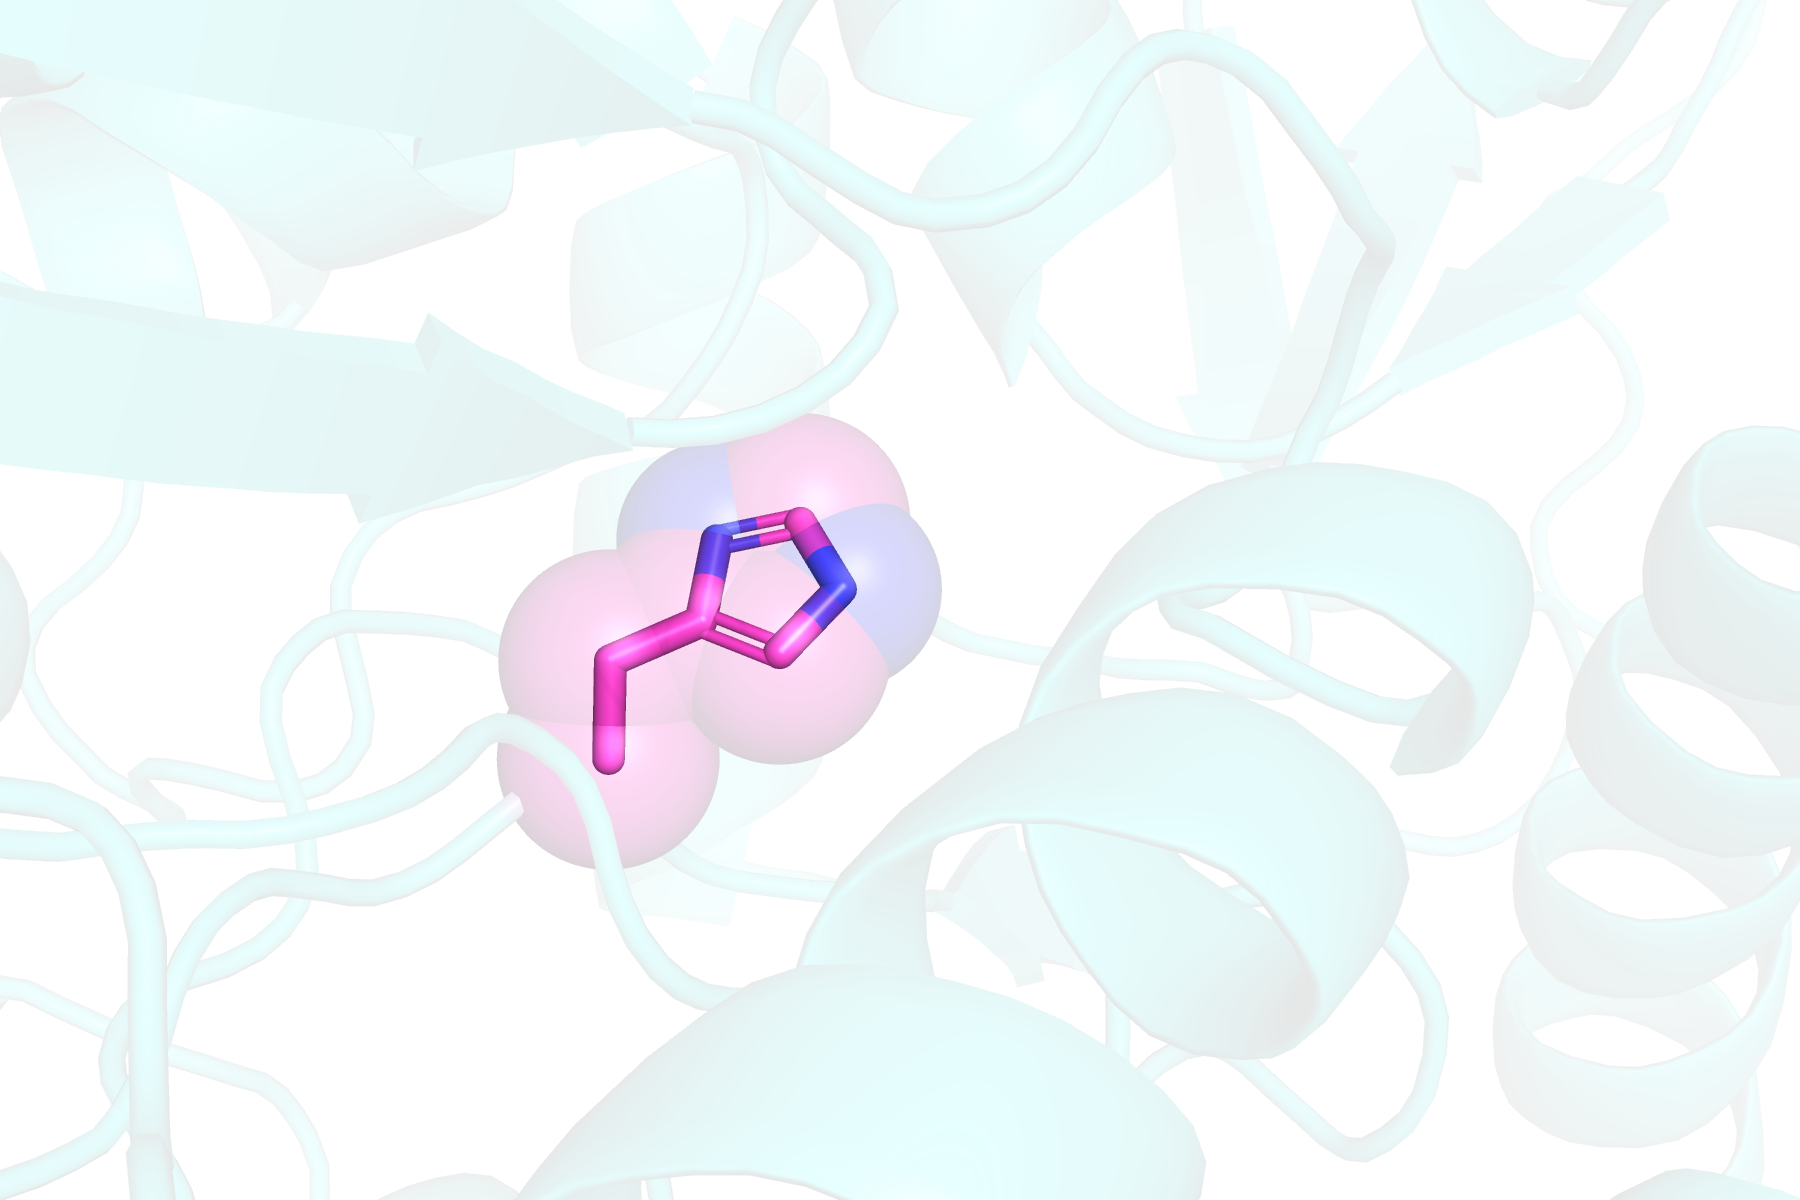

In [21]:
display.Image("./data/parameterization/noLigand.png", width=600, height=600)

While if we conserve the ligand, then the histidine tries to accomodate by rotating. But eventhoug there is no room for it and VdW clashes are oberved.

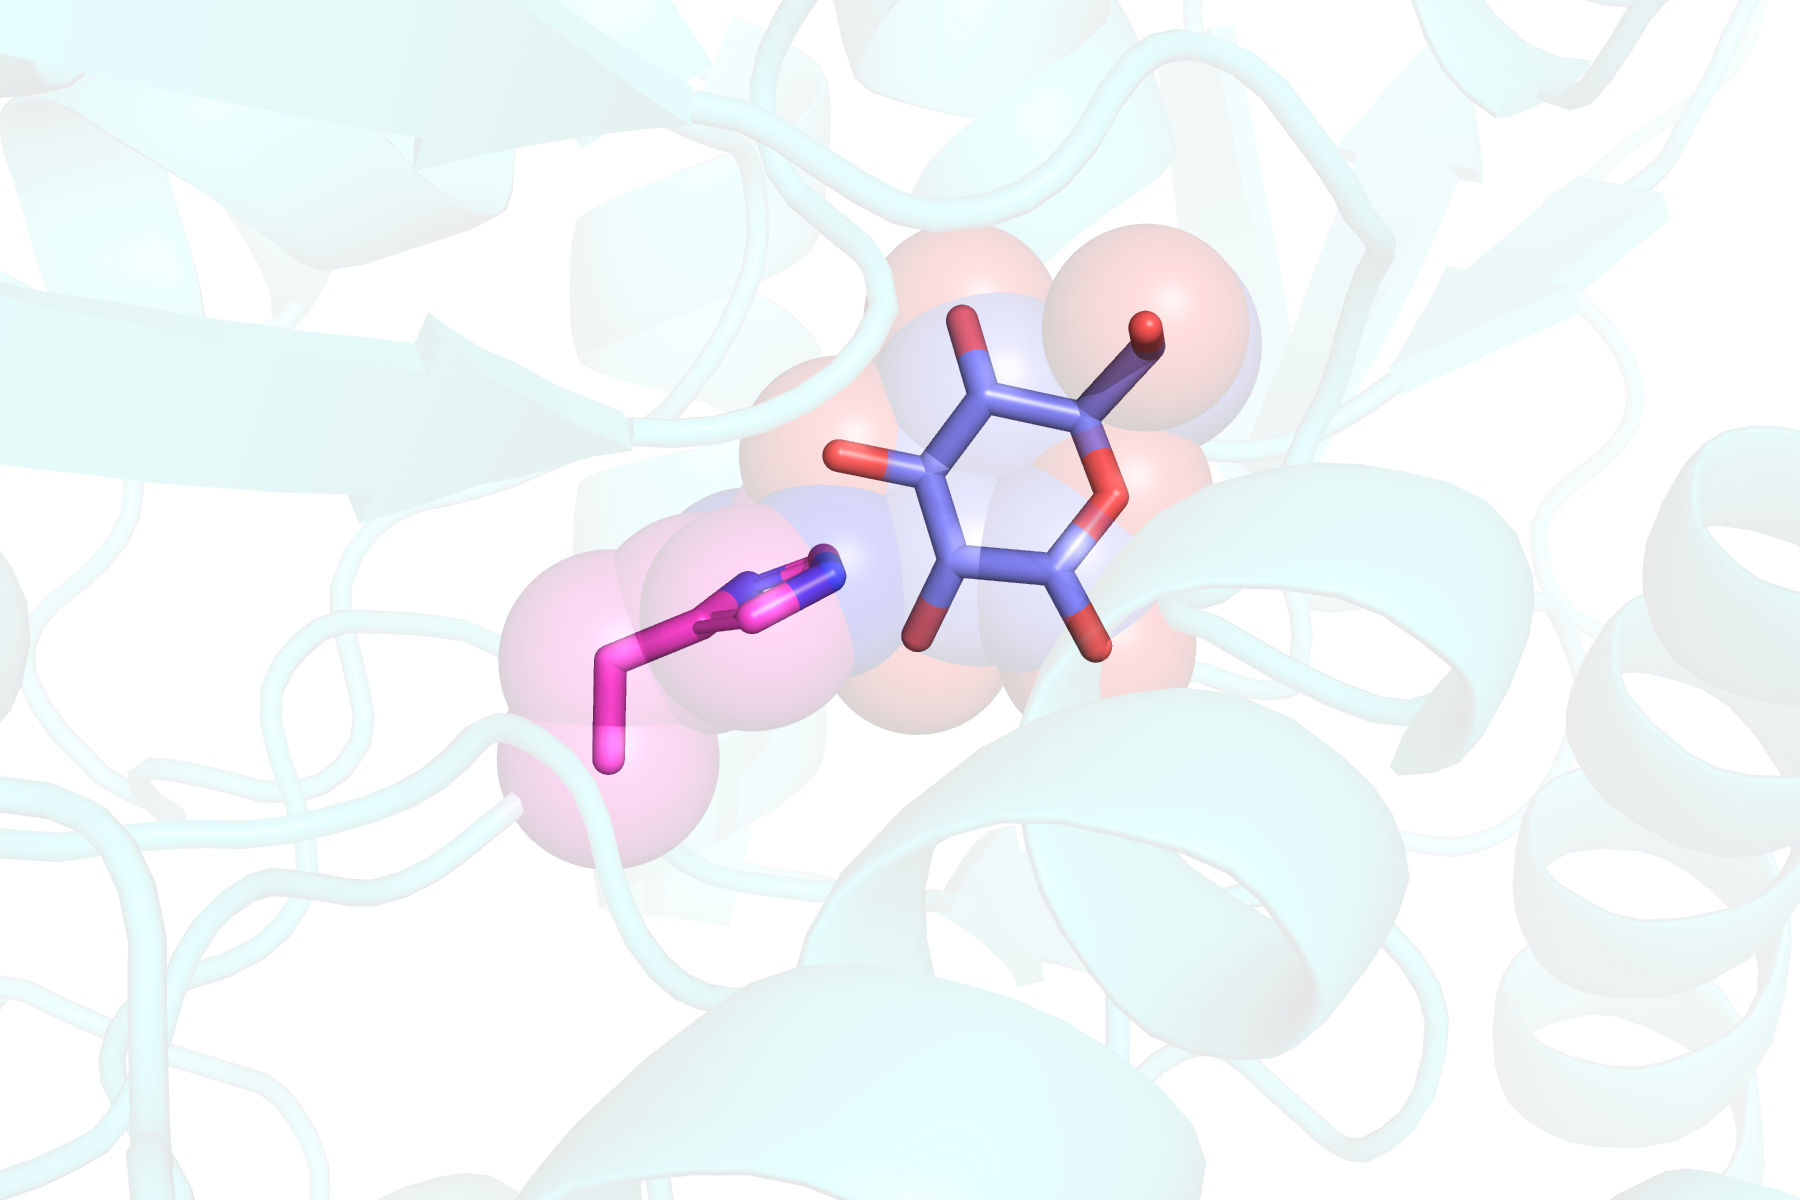

In [22]:
display.Image("./data/parameterization/Ligand.png", width=600, height=600)

Lets observe this within the computed energy terms.

The mutation provokes a VdW Clash that makes the mutational $\Delta \Delta G$ to be very high.

In [26]:
print( "The total energy variation provoked without ligand is: ", float(energyDf_no_GLC.total), "Kcal/Mol." )
print( "The total energy variation provoked with ligand is: ", float(energyDf_GLC.total), "Kcal/Mol." )
print( )
print( "The VdW clashes variation provoked without ligand is: ", float(energyDf_no_GLC.energy_vdwclash), "Kcal/Mol." )
print( "The VdW clashes variation provoked with ligand is: ", float(energyDf_GLC.energy_vdwclash), "Kcal/Mol." )


The total energy variation provoked without ligand is:  1.3088516170314506 Kcal/Mol.
The total energy variation provoked with ligand is:  17.163140089699596 Kcal/Mol.

The VdW clashes variation provoked without ligand is:  0.47348867811104256 Kcal/Mol.
The VdW clashes variation provoked with ligand is:  15.034932249488282 Kcal/Mol.


While for the structure without the ligand (which reproduces the results of having GLC as an unrecognized molecule) the energy, while destabilizing is not causing catastrophic clashes.

As a conclusion, we can infer that almost all the difference of energy provoked by the analyzed mutation is provoked by VdW clashes with the ligand.